# 利用Pandas分析美国选民总统喜好度
[数据集下载地址](https://tianchi.aliyun.com/dataset/79412)
## 数据集来源介绍
**所有候选人信息**
</br>该文件为每个候选人提供一份记录，并显示候选人的信息、总收入、从授权委员会收到的转账、付款总额、给授权委员会的转账、库存现金总额、贷款和债务以及其他财务汇总信息。
</br>数据字段描述详细:https://www.fec.gov/campaign-finance-data/all-candidates-file-description/
</br>关键字段说明
- CAND_ID 候选人ID
- CAND_NAME 候选人姓名
- CAND_PTY_AFFILIATION 候选人党派

</br>数据来源:https://www.fec.gov/files/bulk-downloads/2020/weball20.zip

**候选人委员会链接信息**
</br>该文件显示候选人的身份证号码、候选人的选举年份、联邦选举委员会选举年份、委员会识别号、委员会类型、委员会名称和链接标识号。
</br>信息描述详细:https://www.fec.gov/campaign-finance-data/candidate-committee-linkage-file-description/
</br>关键字段说明
- CAND_ID 候选人ID
- CAND_ELECTION_YR 候选人选举年份
- CMTE_ID 委员会ID

</br>数据来源:https://www.fec.gov/files/bulk-downloads/2020/ccl20.zip

**个人捐款档案信息**
【注意】由于文件较大，本数据集只包含2020.7.22-2020.8.20的相关数据，如果需要更全数据可以通过数据来源中的地址下载。
</br>该文件包含有关收到捐款的委员会、披露捐款的报告、提供捐款的个人、捐款日期、金额和有关捐款的其他信息。
</br>信息描述详细:[https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/)
</br>关键字段说明
- CMTE_ID  委员会ID
- NAME 捐款人姓名
- CITY 捐款人所在市
- State 捐款人所在州
- EMPLOYER 捐款人雇主/公司
- OCCUPATION 捐款人职业

</br>数据来源:https://www.fec.gov/files/bulk-downloads/2020/indiv20.zip
需要提前安装的包：!pip install wordcloud --user

## 数据处理
### 将委员会和候选人一一对应，通过`CAND_ID`关联两个表
由于候选人和委员会的联系表中无候选人姓名，只有候选人ID（`CAND_ID`），所以需要通过`CAND_ID`从候选人表中获取到候选人姓名，最终得到候选人与委员会联系表`ccl`。

In [2]:
# 导入相关处理包
import pandas as pd

In [3]:
# 读取候选人信息，由于原始数据没有表头，需要添加表头
candidates = pd.read_csv("weball20.txt", sep = '|',names=['CAND_ID','CAND_NAME','CAND_ICI','PTY_CD','CAND_PTY_AFFILIATION','TTL_RECEIPTS',
                                                          'TRANS_FROM_AUTH','TTL_DISB','TRANS_TO_AUTH','COH_BOP','COH_COP','CAND_CONTRIB',
                                                          'CAND_LOANS','OTHER_LOANS','CAND_LOAN_REPAY','OTHER_LOAN_REPAY','DEBTS_OWED_BY',
                                                          'TTL_INDIV_CONTRIB','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT','SPEC_ELECTION','PRIM_ELECTION','RUN_ELECTION'
    ,'GEN_ELECTION','GEN_ELECTION_PRECENT','OTHER_POL_CMTE_CONTRIB','POL_PTY_CONTRIB',
                                                          'CVG_END_DT','INDIV_REFUNDS','CMTE_REFUNDS'])
candidates

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,SPEC_ELECTION,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS
0,H8AK00132,"SHEIN, DIMITRI",C,1,DEM,0.00,0.00,367.52,0.00,367.52,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,09/30/2019,0.00,0.0
1,H6AK00045,"YOUNG, DONALD E",I,2,REP,1738661.59,132712.44,1318574.74,0.00,116720.12,...,NaN,NaN,NaN,NaN,NaN,760794.63,500.0,09/30/2020,16625.00,3500.0
2,H8AK01031,"NELSON, THOMAS JOHN",C,2,REP,0.00,0.00,466.51,0.00,466.51,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,03/31/2019,0.00,0.0
3,H8AK00140,"GALVIN, ALYSE",C,3,IND,3905011.97,28500.00,2731435.51,0.00,6245.09,...,NaN,NaN,NaN,NaN,NaN,237983.08,9500.0,09/30/2020,19846.71,0.0
4,H0AL01097,"AVERHART, JAMES",O,1,DEM,63253.10,0.00,55543.57,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,09/30/2020,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,S0WY00186,"HOLTHUS, ROLLAND SCOTT MR",O,2,REP,4291.94,0.00,4291.94,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,07/07/2020,0.00,0.0
3920,S4WY00097,"HARDY, CHARLES E",C,2,REP,0.00,0.00,165.00,0.00,165.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,03/28/2019,0.00,0.0
3921,S4WY00147,"MILLER, BRYAN",O,2,REP,50876.53,3685.02,50876.53,3685.02,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,09/30/2020,0.00,0.0
3922,S6WY00068,"BARRASSO, JOHN A",I,2,REP,883945.37,28538.06,715560.92,0.00,3957773.06,...,NaN,NaN,NaN,NaN,NaN,357150.00,0.0,09/30/2020,0.00,9300.0


In [4]:
# 读取候选人和委员会的联系信息
ccl = pd.read_csv("ccl.txt", sep = '|',names=['CAND_ID','CAND_ELECTION_YR','FEC_ELECTION_YR','CMTE_ID','CMTE_TP','CMTE_DSGN','LINKAGE_ID'])
ccl

,CAND_ID,CAND_ELECTION_YR,FEC_ELECTION_YR,CMTE_ID,CMTE_TP,CMTE_DSGN,LINKAGE_ID
0,C00713602,2019,2020,C00712851,O,U,228963
1,H0AK00105,2020,2020,C00607515,H,P,229250
2,H0AL01055,2020,2020,C00697789,H,P,226125
3,H0AL01063,2020,2020,C00701557,H,P,227053
4,H0AL01071,2020,2020,C00701409,H,P,227054
...,...,...,...,...,...,...,...
6838,S8WV00143,2018,2020,C00689471,S,J,225486
6839,S8WV00143,2018,2020,C00710889,N,U,228546
6840,S8WV00143,2018,2020,C00417063,Y,U,228545
6841,S8WY00189,2018,2020,C00663146,S,P,223873


In [5]:
# 关联两个表数据
ccl = pd.merge(ccl,candidates)
# 提取出所需要的列
ccl = pd.DataFrame(ccl, columns=[ 'CMTE_ID','CAND_ID', 'CAND_NAME','CAND_PTY_AFFILIATION'])
ccl

,CMTE_ID,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION
0,C00697789,H0AL01055,"CARL, JERRY LEE, JR",REP
1,C00701557,H0AL01063,"LAMBERT, DOUGLAS WESTLEY III",REP
2,C00701409,H0AL01071,"PRINGLE, CHRISTOPHER PAUL",REP
3,C00703066,H0AL01089,"HIGHTOWER, BILL",REP
4,C00708867,H0AL01097,"AVERHART, JAMES",DEM
...,...,...,...,...
4356,C00674770,S8WV00143,"MORRISEY, PATRICK MR",REP
4357,C00651075,S8WV00143,"MORRISEY, PATRICK MR",REP
4358,C00689471,S8WV00143,"MORRISEY, PATRICK MR",REP
4359,C00710889,S8WV00143,"MORRISEY, PATRICK MR",REP


数据字段说明：
- CMTE_ID：委员会ID
- CAND_ID：候选人ID
- CAND_NAME：候选人姓名
- CAND_PTY_AFFILIATION：候选人党派

### 将候选人和捐赠人一一对应，通过`CMTE_ID`关联两个表
通过`CMTE_ID`将目前处理好的候选人和委员会关系表与人捐款档案表进行关联，得到候选人与捐赠人一一对应联系表`cil`。

In [8]:
# 读取个人捐赠数据，由于原始数据没有表头，需要添加表头
# 提示：读取本文件大概需要5-10s
itcont = pd.read_csv('itcont_2020_20200722_20200820.txt', sep='|',names=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI',
                                                                         'IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY',
                                                                         'STATE','ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT',
                                                                         'TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
                                                                         'MEMO_TEXT','SUB_ID'])

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\2552027140.py:3: DtypeWarning: Columns (10,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  itcont = pd.read_csv('itcont_2020_20200722_20200820.txt', sep='|',names=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI',


In [10]:
# 将候选人与委员会关系表ccl和个人捐赠数据表itcont合并，通过 CMTE_ID
c_itcont =  pd.merge(ccl,itcont)
# 提取需要的数据列
c_itcont = pd.DataFrame(c_itcont, columns=[ 'CAND_NAME','NAME', 'STATE','EMPLOYER','OCCUPATION',
                                            'TRANSACTION_AMT', 'TRANSACTION_DT','CAND_PTY_AFFILIATION'])
c_itcont

,CAND_NAME,NAME,STATE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,TRANSACTION_DT,CAND_PTY_AFFILIATION
0,"MORGAN, JOSEPH DAVID","MARTIN, WILLIAM II",AZ,RETIRED,RETIRED,100,7242020,REP
1,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,7242020,REP
2,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,7312020,REP
3,"WOOD, DANIEL","HOPKINS, RICHARD",AZ,POWERS-LEAVITT,INSURANCE AGENT,300,8102020,REP
4,"WOOD, DANIEL","PENDLETON, DIANE",AZ,UNEMPLOYED,NaN,500,8072020,REP
...,...,...,...,...,...,...,...,...
756200,"MORRISEY, PATRICK MR","HOWELL, TRESA MRS.",WV,NaN,NaN,500,8152020,REP
756201,"MORRISEY, PATRICK MR","LEWIS, VERONICA MS.",WV,NaN,NaN,200,8022020,REP
756202,"MORRISEY, PATRICK MR","MILLER, MATT F MR.",WV,DUTCH MILLER CHEVROLET,AUTO DEALER,2500,8032020,REP
756203,"MORRISEY, PATRICK MR","POTTER, MELODY L MRS.",WV,TRI-STAR COAL SALES CO.,BUSINESS OWNER,100,8032020,REP


**数据说明**
- CAND_NAME – 接受捐赠的候选人姓名
- NAME – 捐赠人姓名
- STATE – 捐赠人所在州
- EMPLOYER – 捐赠人所在公司
- OCCUPATION – 捐赠人职业
- TRANSACTION_AMT – 捐赠数额（美元）
- TRANSACTION_DT – 收到捐款的日期
- CAND_PTY_AFFILIATION – 候选人党派

## 数据探索与清洗

In [11]:
c_itcont.shape

(756205, 8)

In [12]:
c_itcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756205 entries, 0 to 756204
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CAND_NAME             756205 non-null  object
 1   NAME                  756205 non-null  object
 2   STATE                 756160 non-null  object
 3   EMPLOYER              737413 non-null  object
 4   OCCUPATION            741294 non-null  object
 5   TRANSACTION_AMT       756205 non-null  int64 
 6   TRANSACTION_DT        756205 non-null  int64 
 7   CAND_PTY_AFFILIATION  756205 non-null  object
dtypes: int64(2), object(6)
memory usage: 51.9+ MB


通过上面的探索我们知道目前数据集的一些基本情况，目前数据总共有756205行，8列，总占用内存51.9+MB，`STATE`、`EMPLOYER`、`OCCUPATION`有缺失值，另外日期列目前为int64类型，需要进行转换为str类型。

In [13]:
#空值处理，统一填充 NOT PROVIDED
c_itcont['STATE'].fillna('NOT PROVIDED',inplace=True)
c_itcont['EMPLOYER'].fillna('NOT PROVIDED',inplace=True)
c_itcont['OCCUPATION'].fillna('NOT PROVIDED',inplace=True)

In [14]:
# 对日期TRANSACTION_DT列进行处理
c_itcont['TRANSACTION_DT'] = c_itcont['TRANSACTION_DT'] .astype(str)
# 将日期格式改为年月日  7242020
c_itcont['TRANSACTION_DT'] = [i[3:7]+i[0]+i[1:3] for i in c_itcont['TRANSACTION_DT'] ]

In [15]:
# 再次查看数据信息
c_itcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756205 entries, 0 to 756204
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CAND_NAME             756205 non-null  object
 1   NAME                  756205 non-null  object
 2   STATE                 756205 non-null  object
 3   EMPLOYER              756205 non-null  object
 4   OCCUPATION            756205 non-null  object
 5   TRANSACTION_AMT       756205 non-null  int64 
 6   TRANSACTION_DT        756205 non-null  object
 7   CAND_PTY_AFFILIATION  756205 non-null  object
dtypes: int64(1), object(7)
memory usage: 51.9+ MB


In [16]:
c_itcont

,CAND_NAME,NAME,STATE,EMPLOYER,OCCUPATION,TRANSACTION_AMT,TRANSACTION_DT,CAND_PTY_AFFILIATION
0,"MORGAN, JOSEPH DAVID","MARTIN, WILLIAM II",AZ,RETIRED,RETIRED,100,2020724,REP
1,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,2020724,REP
2,"MORGAN, JOSEPH DAVID","RODRIGUEZ, GERARDO",AZ,VA HOSPITAL,LAB TECH,40,2020731,REP
3,"WOOD, DANIEL","HOPKINS, RICHARD",AZ,POWERS-LEAVITT,INSURANCE AGENT,300,2020810,REP
4,"WOOD, DANIEL","PENDLETON, DIANE",AZ,UNEMPLOYED,NOT PROVIDED,500,2020807,REP
...,...,...,...,...,...,...,...,...
756200,"MORRISEY, PATRICK MR","HOWELL, TRESA MRS.",WV,NOT PROVIDED,NOT PROVIDED,500,2020815,REP
756201,"MORRISEY, PATRICK MR","LEWIS, VERONICA MS.",WV,NOT PROVIDED,NOT PROVIDED,200,2020802,REP
756202,"MORRISEY, PATRICK MR","MILLER, MATT F MR.",WV,DUTCH MILLER CHEVROLET,AUTO DEALER,2500,2020803,REP
756203,"MORRISEY, PATRICK MR","POTTER, MELODY L MRS.",WV,TRI-STAR COAL SALES CO.,BUSINESS OWNER,100,2020803,REP


In [17]:
# 查看数据表中数据类型的列的数据分布情况
c_itcont.describe()

,TRANSACTION_AMT
count,7.562050e+05
mean,1.504307e+02
std,2.320452e+03
min,-5.600000e+03
25%,2.000000e+01
50%,3.500000e+01
75%,1.000000e+02
max,1.500000e+06


In [18]:
# 查看单列的数据发布情况
c_itcont['CAND_NAME'].describe()

count                 756205
unique                   312
top       BIDEN, JOSEPH R JR
freq                  507816
Name: CAND_NAME, dtype: object

## 数据分析

In [19]:
# 计算每个党派的所获得的捐款总额，然后排序，取前十位
c_itcont.groupby("CAND_PTY_AFFILIATION").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\933633489.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_itcont.groupby("CAND_PTY_AFFILIATION").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)


,TRANSACTION_AMT
CAND_PTY_AFFILIATION,
DEM,75961730
REP,37170653
IND,328802
LIB,169202
DFL,76825
GRE,18607
NON,11256
UNK,10195
CON,4117


In [20]:
# 计算每个总统候选人所获得的捐款总额，然后排序，取前十位
c_itcont.groupby("CAND_NAME").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\3053910718.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_itcont.groupby("CAND_NAME").sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)


,TRANSACTION_AMT
CAND_NAME,
"BIDEN, JOSEPH R JR",68111142
"TRUMP, DONALD J.",16594982
"SULLIVAN, DAN",9912465
"JACOBS, CHRISTOPHER L.",6939209
"BLOOMBERG, MICHAEL R.",3451916
"MARKEY, EDWARD J. SEN.",606832
"SHAHEEN, JEANNE",505446
"KENNEDY, JOSEPH P III",467738
"CORNYN, JOHN SEN",345959


获得捐赠最多的党派有`DEM(民主党)`、`REP(共和党)`，分别对应`BIDEN, JOSEPH R JR(拜登)`和`TRUMP, DONALD J.(特朗普)`，从我们目前分析的2020.7.22-2020.8.20这一个月的数据来看，在选民的捐赠数据中拜登代表的民主党完胜特朗普代表的共和党，由于完整数据量过大，所以没有对所有数据进行汇总分析，因此也不能确定11月大选公布结果就一定是拜登当选

In [22]:
# 查看不同职业的人捐款的总额，然后排序，取前十位
c_itcont.groupby('OCCUPATION').sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\3649899558.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_itcont.groupby('OCCUPATION').sum().sort_values("TRANSACTION_AMT",ascending=False).head(10)


,TRANSACTION_AMT
OCCUPATION,
NOT EMPLOYED,24436214
RETIRED,18669950
NOT PROVIDED,5089355
ATTORNEY,4443569
FOUNDER,3519109
PHYSICIAN,3295595
CONSULTANT,1647033
LAWYER,1565976
PROFESSOR,1481260


In [23]:
# 查看每个职业捐款人的数量
c_itcont['OCCUPATION'].value_counts().head(10)

NOT EMPLOYED    224109
RETIRED         151834
ATTORNEY         19666
NOT PROVIDED     14912
PHYSICIAN        14033
CONSULTANT        8333
PROFESSOR         8022
TEACHER           8013
ENGINEER          7922
SALES             6435
Name: OCCUPATION, dtype: int64

从捐款人的职业这个角度分析，我们会发现`NOT EMPLOYED(自由职业)`的总捐赠额是最多，通过查看每个职业捐赠的人数来看，我们就会发现是因为`NOT EMPLOYED(自由职业)`人数多的原因，另外退休人员捐款人数也特别多，所以捐款总数对应的也多，其他比如像：律师、创始人、医生、顾问、教授、主管这些高薪人才虽然捐款总人数少，但是捐款总金额也占据了很大比例。

In [24]:
# 每个州获捐款的总额，然后排序，取前五位
c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False).head(5)

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\3625674182.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False).head(5)


,TRANSACTION_AMT
STATE,
CA,19999115
NY,11468537
FL,8128789
TX,8101871
MA,5187957


In [25]:
# 查看每个州捐款人的数量
c_itcont['STATE'].value_counts().head(5)

CA    127895
TX     54457
FL     54343
NY     49453
MA     29314
Name: STATE, dtype: int64

最后查看每个州的捐款总金额，我们会发现`CA(加利福利亚)`、`NY(纽约)`、`FL(弗罗里达)`这几个州的捐款是最多的，在捐款人数上也是在Top端，另一方面也凸显出这些州的经济水平发达。
大家也可以通过数据查看下上面列举的高端职业在各州的分布情况，进行进一步的分析探索。

## 数据可视化

In [26]:
# 导入matplotlib中的pyplot
import matplotlib.pyplot as plt

# 导入词云库
from wordcloud import WordCloud,ImageColorGenerator

## 按州总捐款数和总捐款人数柱状图

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\2252577218.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  st_amt = c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False)[:10]


<AxesSubplot:xlabel='STATE'>

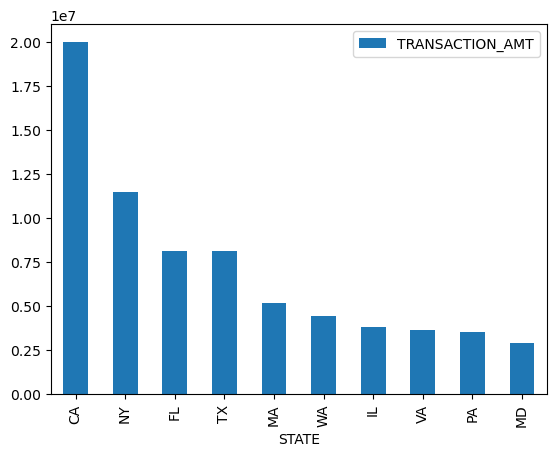

In [27]:
# 各州总捐款数可视化
st_amt = c_itcont.groupby('STATE').sum().sort_values("TRANSACTION_AMT",ascending=False)[:10]
st_amt=pd.DataFrame(st_amt, columns=['TRANSACTION_AMT'])
st_amt.plot(kind='bar')

## 各州捐款总人数可视化

<AxesSubplot:xlabel='STATE'>

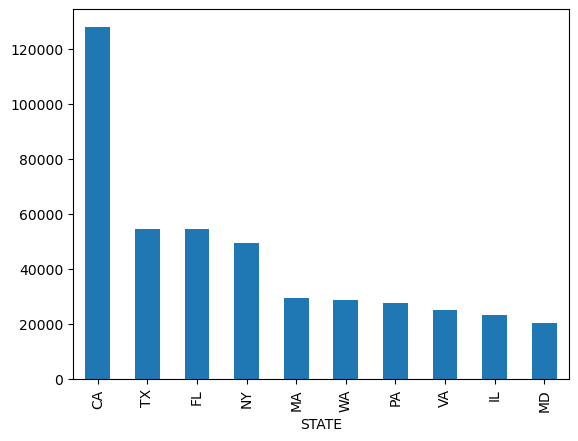

In [28]:
# 各州捐款总人数可视化，取前10个州的数据
st_amt = c_itcont.groupby('STATE').size().sort_values(ascending=False).head(10)
st_amt.plot(kind='bar')

C:\Users\Wu Kaixiang\AppData\Local\Temp\ipykernel_9240\1468728801.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  biden_state = biden.groupby('STATE').sum().sort_values("TRANSACTION_AMT", ascending=False).head(10)


array([<AxesSubplot:ylabel='TRANSACTION_AMT'>], dtype=object)

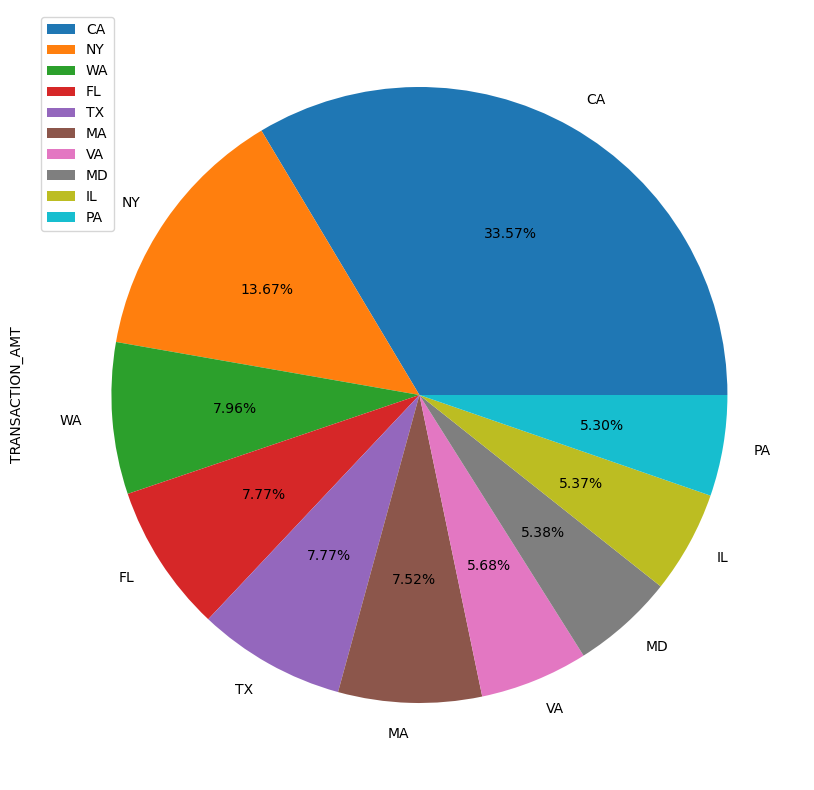

In [29]:
# 从所有数据中取出支持拜登的数据
biden = c_itcont[c_itcont['CAND_NAME']=='BIDEN, JOSEPH R JR']
# 统计各州对拜登的捐款总数
biden_state = biden.groupby('STATE').sum().sort_values("TRANSACTION_AMT", ascending=False).head(10)
# 饼图可视化各州捐款数据占比
biden_state.plot.pie(figsize=(10, 10),autopct='%0.2f%%',subplots=True)

## 总捐最多的候选人捐赠者词云图

In [31]:
# 首先下载图片模型,这里提供的是已经处理好的图片，有兴趣的选手可以自己写代码进行图片处理
# 处理结果：需要将人图像和背景颜色分离，并纯色填充，词云才会只显示在人图像区域
# 拜登原图：https://img.alicdn.com/tfs/TB1pUcwmZVl614jSZKPXXaGjpXa-689-390.jpg
# 拜登处理后图片：https://img.alicdn.com/tfs/TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg
# 特朗普原图：https://img.alicdn.com/tfs/TB1D0l4pBBh1e4jSZFhXXcC9VXa-298-169.jpg
# 特朗普处理后图片：https://img.alicdn.com/tfs/TB1BoowmZVl614jSZKPXXaGjpXa-298-169.jpg
# 这里我们先下载处理后的图片
!wget https://img.alicdn.com/tfs/TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg

--2022-12-24 11:58:42--  https://img.alicdn.com/tfs/TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg
Resolving img.alicdn.com (img.alicdn.com)... 124.165.205.251, 124.165.205.252
Connecting to img.alicdn.com (img.alicdn.com)|124.165.205.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4236 (4.1K) [image/jpeg]
Saving to: 'TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg'

     0K ....                                                  100% 2.03M=0.002s

2022-12-24 11:58:42 (2.03 MB/s) - 'TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg' saved [4236/4236]



In [32]:
# 由于下载图片文件名过长，我们对文件名进行重命名
import os
os.rename('TB10Jx4pBBh1e4jSZFhXXcC9VXa-689-390.jpg', 'biden.jpg')

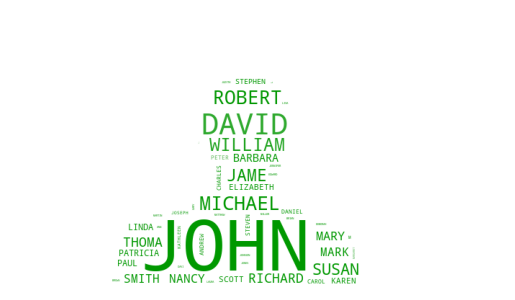

In [33]:
# 将所有捐赠者姓名连接成一个字符串
data = ' '.join(biden["NAME"].tolist())
# 读取图片文件
bg = plt.imread("biden.jpg")
# 生成
wc = WordCloud(# FFFAE3
    background_color="white",  # 设置背景为白色，默认为黑色
    width=890,  # 设置图片的宽度
    height=600,  # 设置图片的高度
    mask=bg,    # 画布
    margin=10,  # 设置图片的边缘
    max_font_size=100,  # 显示的最大的字体大小
    random_state=20,  # 为每个单词返回一个PIL颜色
).generate_from_text(data)
# 图片背景
bg_color = ImageColorGenerator(bg)
# 开始画图
plt.imshow(wc.recolor(color_func=bg_color))
# 为云图去掉坐标轴
plt.axis("off")
# 画云图，显示
# 保存云图
wc.to_file("biden_wordcloud.png")